# 1. Import Libraries

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from ydata_profiling import ProfileReport
from phik import phik_matrix

%matplotlib inline

# 2. Data Download from Kaggle

In [13]:
out_path = "../Data/Raw/"
import kagglehub
import shutil

# Download latest version
#path = kagglehub.dataset_download("brandao/diabetes")
#shutil.move(path, out_path)
raw_df = pd.read_csv("../Data/Raw/1/diabetic_data.csv")
raw_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# 3. Initial Data Inspection

In [14]:
print(raw_df.head())
print(raw_df.shape)
print(raw_df.info())
print(raw_df.describe())

# Duplicates check
print("Unique encounter_id:", raw_df["encounter_id"].nunique())
print("Total rows:", len(raw_df))


   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

In [15]:
# Raw Data Profiling Report
profile = ProfileReport(raw_df, title="Raw Data Profiling", explorative=True)
profile.to_file("../Reports/pydata_profiling/diabetes_report_rawData.html")
print("Raw profiling report saved.")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 18.92it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Raw profiling report saved.


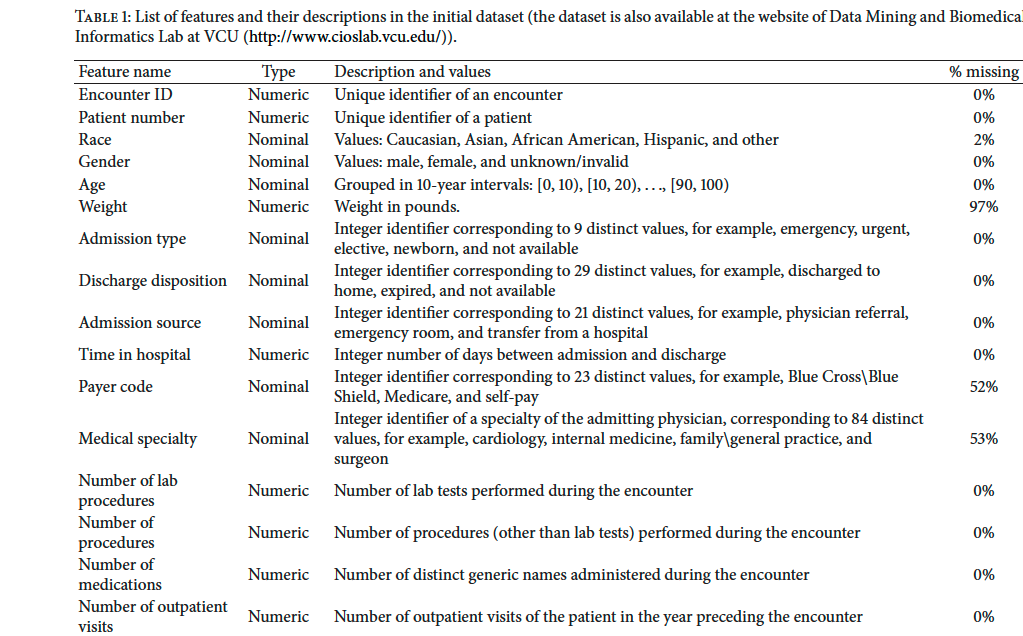
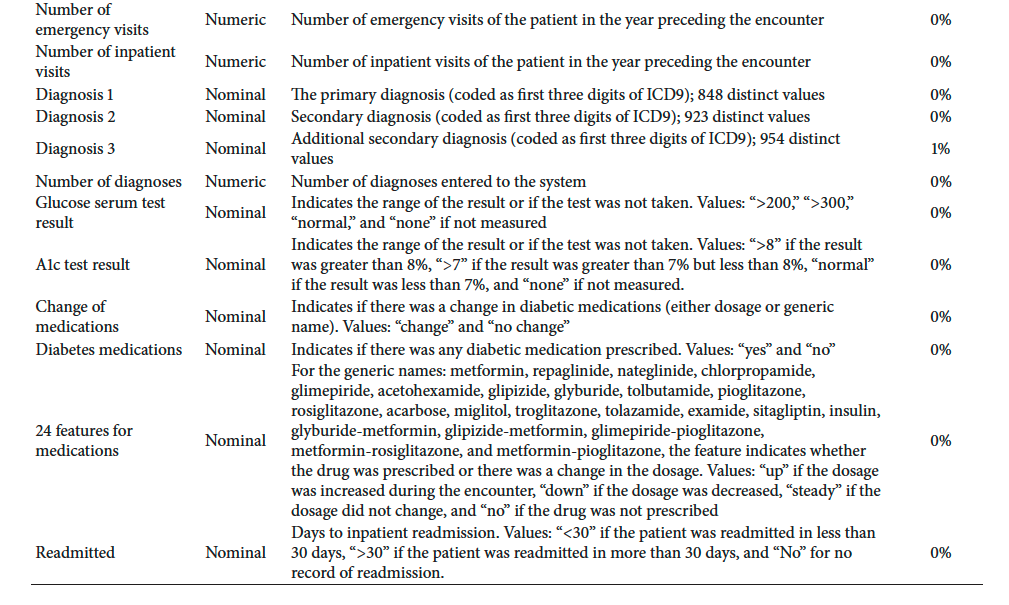

## 4. Data Cleaning and Transformation

(a) Drop unwanted columns

In [16]:
cleaned_df = raw_df.drop(columns=[
    'citoglipton', 'examide', 'patient_nbr', 'encounter_id'
])
# These 2 columns has 1 unique values only & encounter_id, patient_nbr 
# columns as they are ids and dont hold any meaning

(b) Replace "?" with NaN

In [17]:
cleaned_df = cleaned_df.replace(['?', r'^\s*$'], np.nan)

(c) Remove leakage columns


Would I know this information before the patient is discharged? --> For all columns
1) payer_code --> highly missing and doesnt make sence as to which insurance companies pays the bill impacts the readmission in diabetic patient
Removing these two columns

In [18]:
cleaned_df.drop(['payer_code'], axis=1, inplace=True)
cleaned_df.head(), cleaned_df.shape

(              race  gender      age weight  admission_type_id  \
 0        Caucasian  Female   [0-10)    NaN                  6   
 1        Caucasian  Female  [10-20)    NaN                  1   
 2  AfricanAmerican  Female  [20-30)    NaN                  1   
 3        Caucasian    Male  [30-40)    NaN                  1   
 4        Caucasian    Male  [40-50)    NaN                  1   
 
    discharge_disposition_id  admission_source_id  time_in_hospital  \
 0                        25                    1                 1   
 1                         1                    7                 3   
 2                         1                    7                 2   
 3                         1                    7                 2   
 4                         1                    7                 1   
 
           medical_specialty  num_lab_procedures  ...  tolazamide  insulin  \
 0  Pediatrics-Endocrinology                  41  ...          No       No   
 1                

(d) Target clarity

In [19]:
#Identify the distribution of <30, >30 & No and decide whether to analyse 
# it is a binary class or multi class classification problem
print(cleaned_df['readmitted'].value_counts(normalize=True) * 100)

readmitted
NO     53.911916
>30    34.928169
<30    11.159916
Name: proportion, dtype: float64


Not highly imbalance dataset hence going with multi-class classification to early predict the readmission time as <30, >30 or Not

In an early prediction model, high-risk predictions can trigger real-time interventions - such as closer monitoring, medication review, or social support - potentially reducing readmission risk.
In contrast, discharge-time models primarily inform follow-up and resource allocation, since the patient is already leaving the hospital.

Hence our main goal here is an early prediction multi-class classification model 

(e) Identify high cardinality columns i.e., columns with high number of unique values

In [20]:
cleaned_df.nunique().sort_values(ascending=False)
# low cardinality <10, medium 10-100, high >100
# diag_1,2,3 and num_lab_procedures has high cardinality, 

diag_3                      789
diag_2                      748
diag_1                      716
num_lab_procedures          118
num_medications              75
medical_specialty            72
number_outpatient            39
number_emergency             33
discharge_disposition_id     26
number_inpatient             21
admission_source_id          17
number_diagnoses             16
time_in_hospital             14
age                          10
weight                        9
admission_type_id             8
num_procedures                7
race                          5
glipizide                     4
glyburide-metformin           4
insulin                       4
miglitol                      4
acarbose                      4
rosiglitazone                 4
pioglitazone                  4
glyburide                     4
repaglinide                   4
chlorpropamide                4
nateglinide                   4
glimepiride                   4
metformin                     4
A1Cresul

# 5. ICD9 Mapping (Feature Engineering)

In [21]:
# Got the ICD9 codes from https://www.icd9data.com/2012/Volume1/default.htm 
#!pip install openpyxl

ICD9_codeDB = pd.read_excel("../Data/Raw/ICD9_Codes.xlsx")
ICD9_codeDB[['ICD9_lower', 'ICD9_upper']] = ICD9_codeDB['ICD9_code'].str.split('-', expand=True)

def find_diagnosis(val):
    if pd.isna(val) or val == "?":
        return "Unknown"
    val_str = str(val)
    for _, row in ICD9_codeDB.iterrows():
        low = str(row["ICD9_lower"])
        high = str(row["ICD9_upper"])
        try:
            if float(low) <= float(val) <= float(high):
                return row["Diagnosis"]
        except:
            if low <= val_str <= high:
                return row["Diagnosis"]
    return "Unknown"

cleaned_df['diag_1_category'] = cleaned_df['diag_1'].apply(find_diagnosis)
cleaned_df['diag_2_category'] = cleaned_df['diag_2'].apply(find_diagnosis)
cleaned_df['diag_3_category'] = cleaned_df['diag_3'].apply(find_diagnosis)
# Drop old diagnosis columns
cleaned_df.drop(['diag_1','diag_2','diag_3'], axis=1, inplace=True)
cleaned_df.head(), cleaned_df.shape


(              race  gender      age weight  admission_type_id  \
 0        Caucasian  Female   [0-10)    NaN                  6   
 1        Caucasian  Female  [10-20)    NaN                  1   
 2  AfricanAmerican  Female  [20-30)    NaN                  1   
 3        Caucasian    Male  [30-40)    NaN                  1   
 4        Caucasian    Male  [40-50)    NaN                  1   
 
    discharge_disposition_id  admission_source_id  time_in_hospital  \
 0                        25                    1                 1   
 1                         1                    7                 3   
 2                         1                    7                 2   
 3                         1                    7                 2   
 4                         1                    7                 1   
 
           medical_specialty  num_lab_procedures  ...  glipizide-metformin  \
 0  Pediatrics-Endocrinology                  41  ...                   No   
 1                

# 6. Missing Value Imputation Rules (Domain Based)

Types of Missingness: 

1) MCAR – Missing Completely at Random

Missingness is unrelated to any variable or outcome.

Example: A lab result missing due to a random system error.

Safe to impute (mean/median) or drop if the proportion is small.
Implication: Standard imputations won’t bias results.

2) MAR – Missing at Random

Missingness is related to other observed variables, but not the missing value itself.

Example: Blood glucose tests more often missing in younger, healthier patients.

Use model-based imputations (e.g., regression, KNN).
Implication: Conditional methods best preserve data relationships.

3) MNAR – Missing Not at Random

Missingness depends on the unobserved value itself (informative).

Example: A1C test not performed because clinician didn’t suspect diabetes.

Add a missing indicator or treat “missing” as a meaningful category.
Implication: Missingness carries predictive information — don’t blindly impute.

![image-2.png](attachment:image-2.png)

Imputation strategy
1) Race --> can be imputed with mode of the data
2) Weight --> 1 if measured else 0
3) Medical_speciality --> replace it with unknown
4) diag_3 (now diag_3_category) --> replace it with 'NoSecondaryDiagnosis'
5) max_glu_serum --> Replace missing with 'NotPerformed'
6) A1cresult --> Replace missing with 'NotPerformed'


In [22]:
# Since max_glu_serum & A1Cresult had >50% of the data as missing we wont be removing these 2 columns because
# NAN indicate that the test was not performed

cleaned_df['race'].fillna(cleaned_df['race'].mode()[0], inplace=True)
cleaned_df['weight'] = cleaned_df['weight'].apply(lambda x: 1 if not pd.isna(x) else 0)
cleaned_df['medical_specialty'].fillna('Unknown', inplace=True)
cleaned_df['diag_3_category'].fillna('NoSecondaryDiagnosis', inplace=True)
cleaned_df['max_glu_serum'].fillna('NotPerformed', inplace=True)
cleaned_df['A1Cresult'].fillna('NotPerformed', inplace=True)
cleaned_df.isna().sum().sort_values(ascending=False)


/var/folders/kn/l8641p151k93sbb2vg6hs5ph0000gn/T/ipykernel_10651/3660030074.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_df['race'].fillna(cleaned_df['race'].mode()[0], inplace=True)
/var/folders/kn/l8641p151k93sbb2vg6hs5ph0000gn/T/ipykernel_10651/3660030074.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

race                        0
acetohexamide               0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
insulin                     0
glyburide-metformin         0
glipizide-metformin         0
glimepiride-pioglitazone    0
metformin-rosiglitazone     0
metformin-pioglitazone      0
change                      0
diabetesMed                 0
readmitted                  0
diag_1_category             0
diag_2_category             0
glipizide                   0
glimepiride                 0
gender                      0
chlorpropamide              0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
medical_specialty           0
num_lab_procedures          0
num_proced

In [23]:
# Cleaned Data Profiling
cleaned_profile = ProfileReport(
    cleaned_df,
    title="Cleaned Data Profiling",
    explorative=True
)
cleaned_profile.to_file("../Reports/pydata_profiling/diabetes_report_CleanedData.html")

print("Cleaned data profiling saved.")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:02<00:00, 16.74it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Cleaned data profiling saved.


# 7A. Categorical Feature Distribution PDF

Understand distributions, relationships with target, and correlations.
Remove the columns that highly correlated among themselves; 

Univariate Analysis: Univariate analysis examines individual variables to understand their distributions and summary statistics. This includes calculating measures such as mean, median, mode, and standard deviation, and visualizing the data using histograms, bar charts, box plots, and violin plots.

Bivariate Analysis: Bivariate analysis explores the relationship between two variables. It uncovers patterns through techniques like scatter plots, pair plots, and heatmaps. This helps to identify potential associations or dependencies between variables.

Multivariate Analysis: Multivariate analysis involves examining more than two variables simultaneously to understand their relationships and combined effects. Techniques such as contour plots, and principal component analysis (PCA) are commonly used in multivariate EDA.

In [24]:
import math
from matplotlib.backends.backend_pdf import PdfPages

def plot_categorical_distribution():

    cat_cols = [c for c in cleaned_df.columns if cleaned_df[c].dtype == 'O']
    n_per_fig = 6
    n_cols = 3

    with PdfPages("../Reports/Figures/categorical_plots.pdf") as pdf:
        for start in range(0, len(cat_cols), n_per_fig):
            subset = cat_cols[start:start+n_per_fig]
            n_rows = math.ceil(len(subset) / n_cols)

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(9 * n_cols, 10 * n_rows))
            axes = axes.ravel()

            for idx, col in enumerate(subset):
                counts = cleaned_df[col].value_counts().head(15)
                counts.plot(kind="bar", ax=axes[idx])
                axes[idx].set_title(col)
                axes[idx].tick_params(axis='x', rotation=45)

            for j in range(idx+1, len(axes)):
                axes[j].axis("off")

            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)

plot_categorical_distribution()

# 7B. Numerical Feature Distribution PDF

In [25]:
def plot_numerical_distribution():

    num_cols = [c for c in cleaned_df.columns if cleaned_df[c].dtype in ['int64','float64']]
    n_per_fig = 6
    n_cols = 3

    with PdfPages("../Reports/Figures/numerical_plots.pdf") as pdf:
        for start in range(0, len(num_cols), n_per_fig):
            subset = num_cols[start:start+n_per_fig]
            n_rows = math.ceil(len(subset) / n_cols)

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(9*n_cols, 10*n_rows))
            axes = axes.ravel()

            for idx, col in enumerate(subset):
                data = cleaned_df[col].dropna()

                ax1 = axes[idx]
                ax1.hist(data, alpha=0.5)
                ax2 = ax1.twinx()
                data.plot(kind="kde", ax=ax2)

                ax1.set_title(col)
                ax1.tick_params(axis='x', rotation=45)

            for j in range(idx+1, len(axes)):
                axes[j].axis("off")

            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)

plot_numerical_distribution()

# 7C. Boxplots for Outliers


In [26]:
num_cols = cleaned_df.select_dtypes(include=['int64','float64']).columns
n_per_fig = 4
n_cols = 2
n_rows = 2

with PdfPages("../Reports/Figures/boxplots_outliers.pdf") as pdf:
    for start in range(0, len(num_cols), n_per_fig):
        subset = num_cols[start:start+n_per_fig]

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
        axes = axes.ravel()

        for idx, col in enumerate(subset):
            cleaned_df.boxplot(column=col, ax=axes[idx], grid=False)
            axes[idx].set_title(col)

        for j in range(len(subset), len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)


# 7D. Pearson Correlation Heatmap

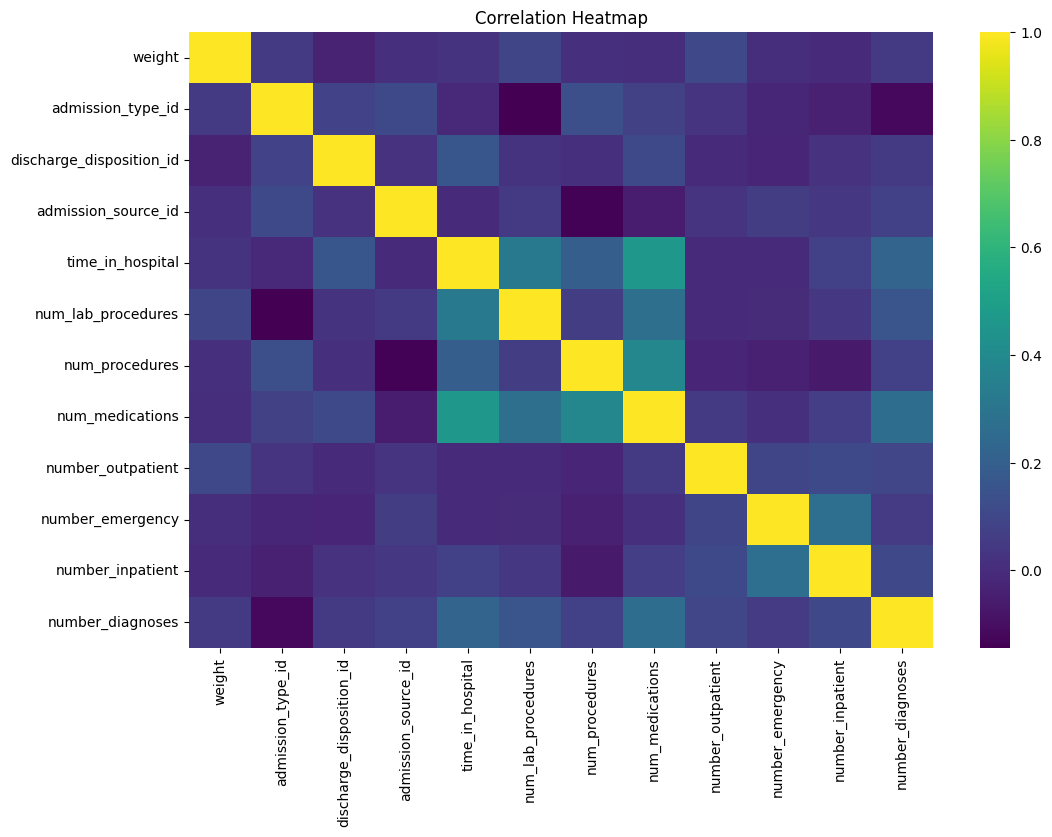

In [27]:
# Create folder if not exists
save_dir = "../Reports/Figures"
os.makedirs(save_dir, exist_ok=True)

plt.figure(figsize=(12,8))
corr = cleaned_df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="viridis")
plt.title("Correlation Heatmap")

# SAVE the plot
plt.savefig(os.path.join(save_dir, "correlation_heatmap.png"),
            dpi=300, bbox_inches="tight")

plt.show()


# 7E. Phik Correlation Matrix + Profiling

interval columns not set, guessing: ['weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


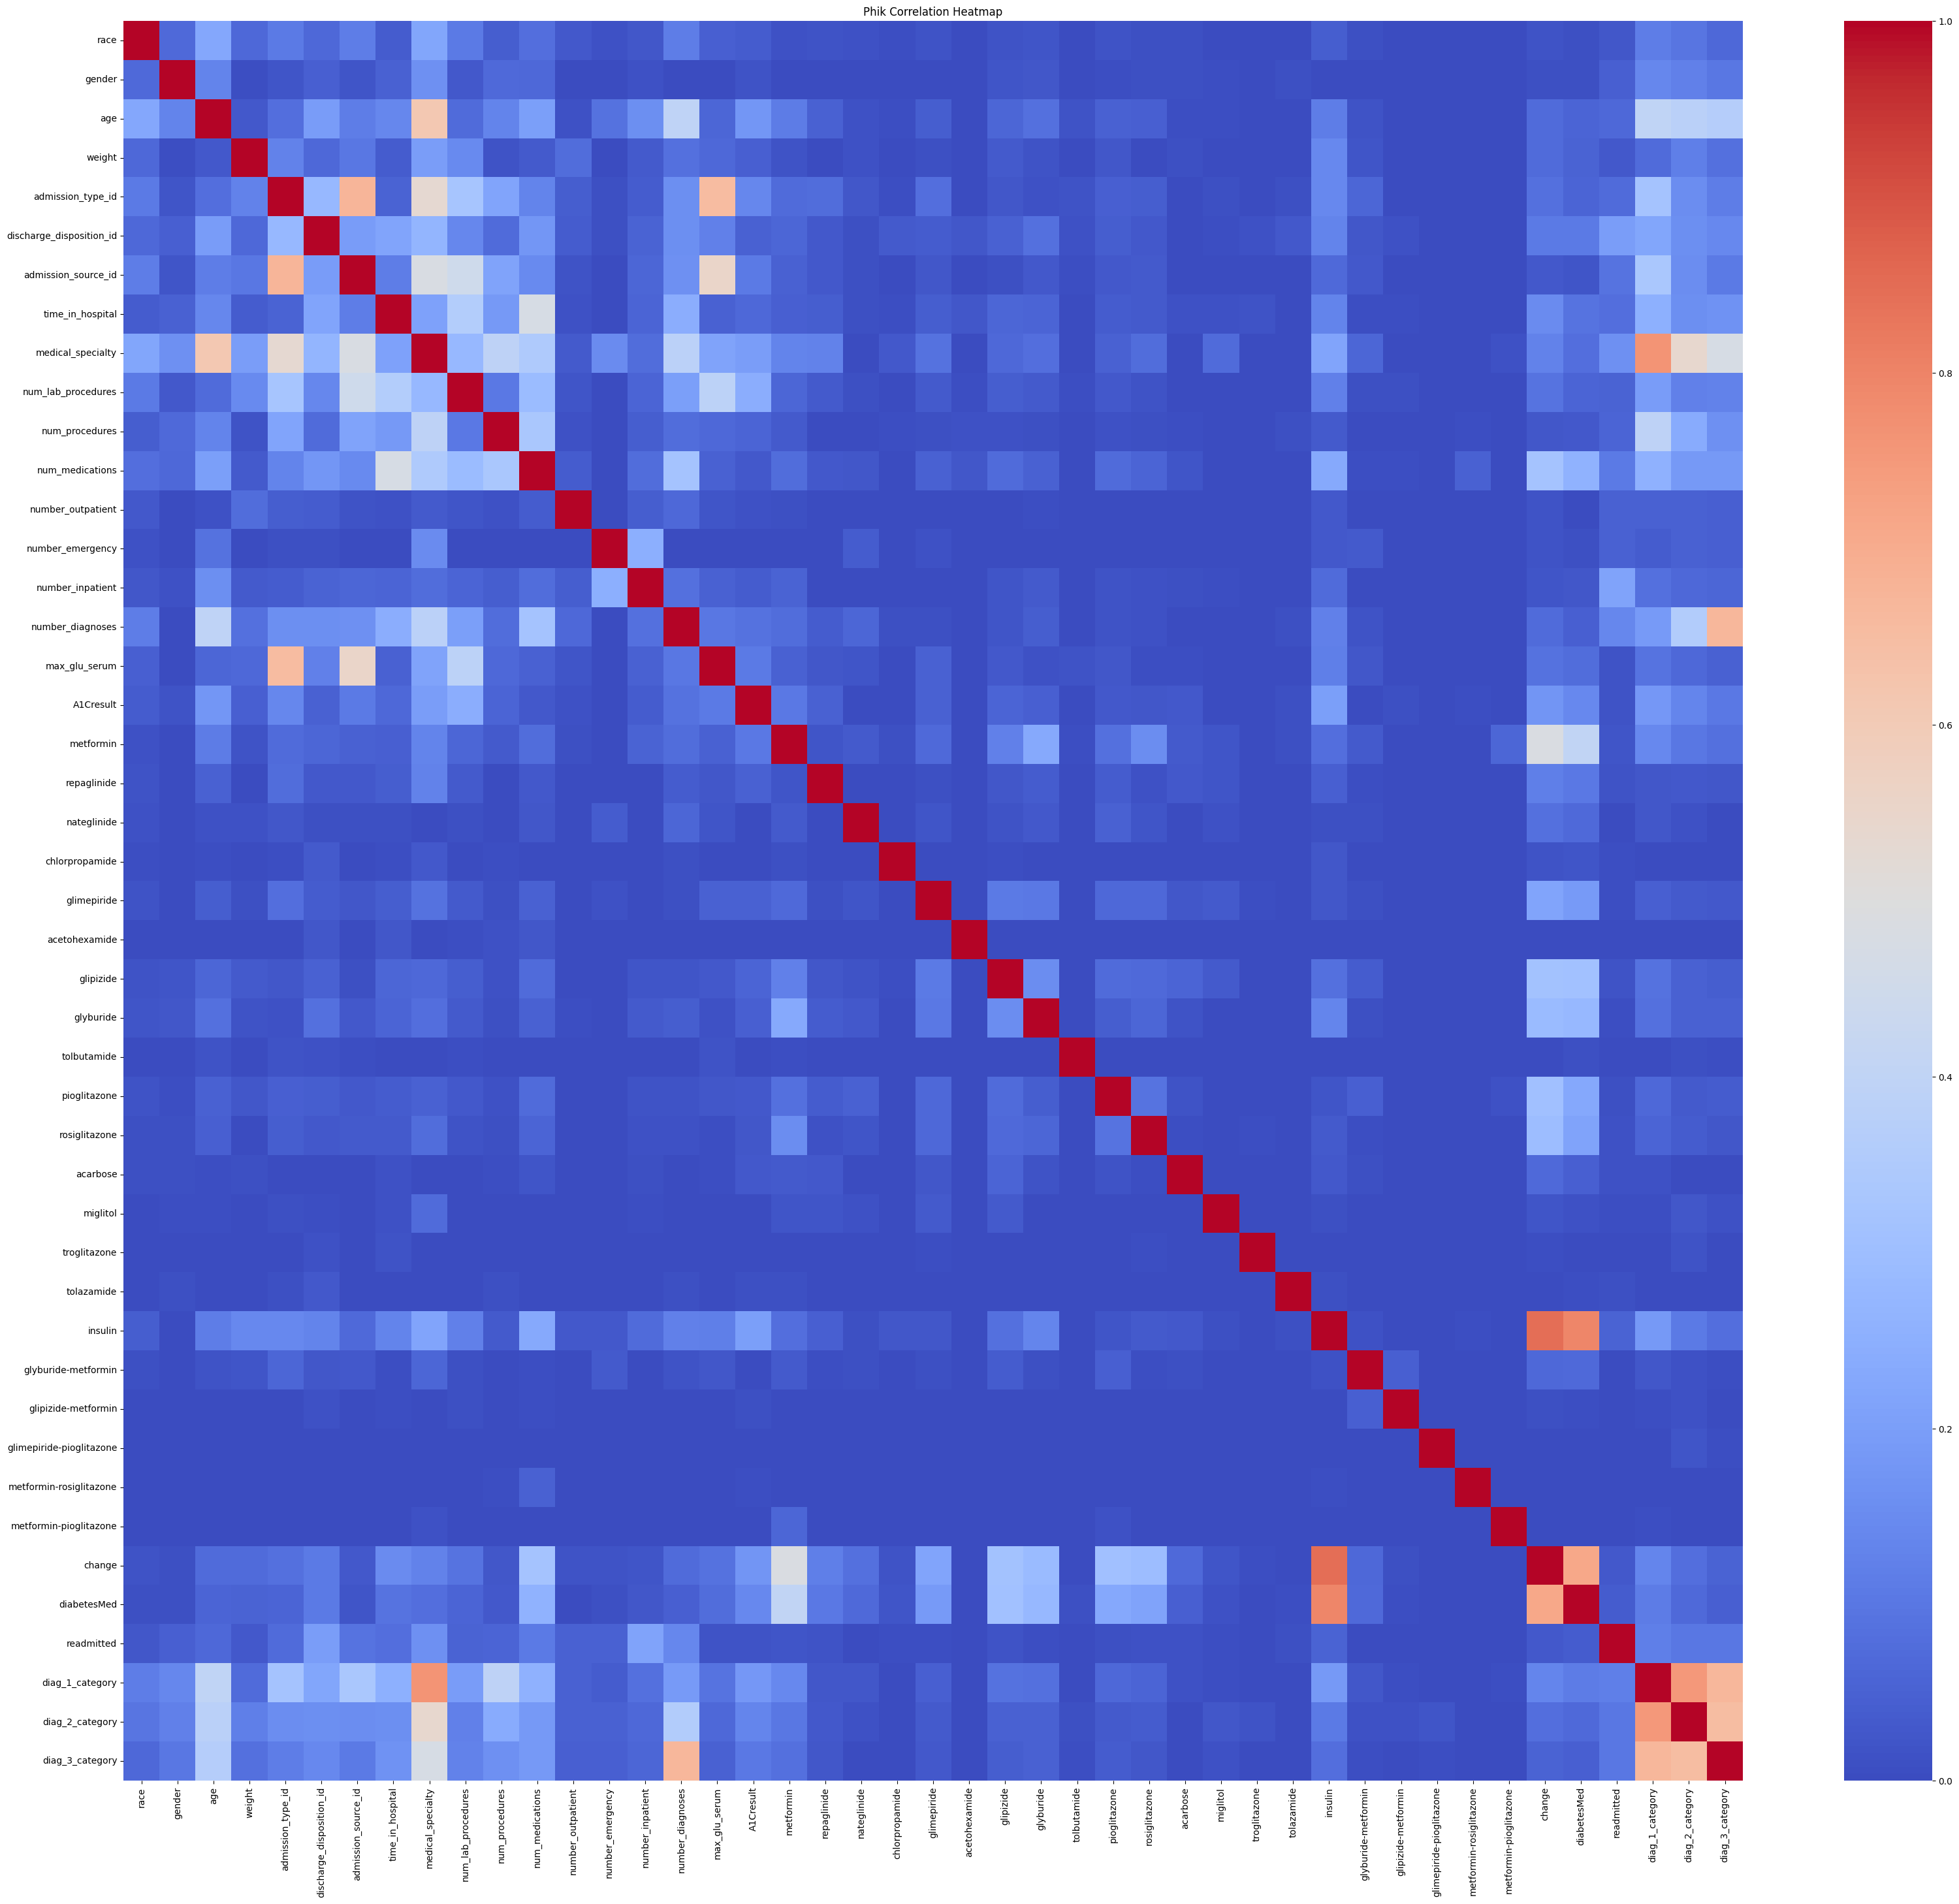

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:01<00:00, 22.87it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
save_dir = "../Reports/Figures"
os.makedirs(save_dir, exist_ok=True)
phik_corr = cleaned_df.phik_matrix()
plt.figure(figsize=(40,35))
sns.heatmap(phik_corr, cmap='coolwarm')
plt.title("Phik Correlation Heatmap")
# SAVE heatmap
plt.savefig(os.path.join(save_dir, "phik_correlation_heatmap.png"),
            dpi=300, bbox_inches="tight")
plt.show()

# Profiling report
profile = cleaned_df.profile_report(
    title="Phik Report",
    correlations={"phi_k": {"calculate": True}}
)
profile.to_file("../Reports/pydata_profiling/diabetes_report_PhikCorr.html")


# 7F. High Correlation Pair Detection


In [29]:
THRESHOLD = 0.6
phik_abs = phik_corr.abs().copy()
np.fill_diagonal(phik_abs.values, 0)

high_pairs = []
cols = phik_abs.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        val = phik_abs.iloc[i, j]
        if val >= THRESHOLD:
            high_pairs.append((cols[i], cols[j], val))

high_corr_df = pd.DataFrame(high_pairs, columns=["var1","var2","phik"])
high_corr_df.sort_values("phik", ascending=False)

,var1,var2,phik
5,insulin,change,0.843831
6,insulin,diabetesMed,0.793598
3,medical_specialty,diag_1_category,0.763436
8,diag_1_category,diag_2_category,0.753078
7,change,diabetesMed,0.714114
1,admission_type_id,admission_source_id,0.672956
9,diag_1_category,diag_3_category,0.668845
4,number_diagnoses,diag_3_category,0.668050
2,admission_type_id,max_glu_serum,0.654870
10,diag_2_category,diag_3_category,0.649550


# 8. Drop Columns Based on Correlation & Domain Knowledge

In [30]:
# medical_specialty → Dropped because it has many missing/“Unknown” values and
# adds little reliable signal.
# change → Dropped because it is a derived flag and highly redundant with insulin usage.
# diabetesMed → Dropped because it overlaps strongly with insulin and 
# provides no additional information.

#cleaned_df.drop(['medical_specialty','change','diabetesMed'], axis=1, inplace=True)
cleaned_df.shape

(101766, 45)

# 9. Save Cleaned Data

In [31]:
save_path = os.path.join('..', 'Data', 'Processed', 'cleaned_df.pkl')

with open(save_path, 'wb') as f:
    pickle.dump(cleaned_df, f)

print("Saved cleaned_df.pkl →", save_path)

Saved cleaned_df.pkl → ../Data/Processed/cleaned_df.pkl
